# test.find.best_model.ipynb
- Gregory S.H. Paek
- 22.10.04
- Select observational data and find which models are the best-fitted

In [1]:
import glob, os
from astropy.io import ascii
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, vstack
import matplotlib as mpl
from astropy import units as u
import speclite.filters
import time
import multiprocessing
from itertools import repeat
from scipy.optimize import curve_fit


In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"

mpl.rcParams["axes.titlesize"] = 14
mpl.rcParams["axes.labelsize"] = 20
plt.rcParams['savefig.dpi'] = 200
plt.rc('font', family='serif')

In [3]:
from helper import makeSpecColors
from helper import convert_flam2fnu
from helper import get_wollaeger
from helper import convert_app2abs
from helper import convert_abs2app
kncbtbl = get_wollaeger()
from helper import get_bandwidth_table
bdwtbl = get_bandwidth_table()
#	speclite
from helper import get_speclite_med
meds = get_speclite_med()
mlam = meds.effective_wavelengths
mbdw = bdwtbl['bandwidth'][bdwtbl['group']=='Med']*u.Angstrom
from helper import get_speclite_sdss
sdss = get_speclite_sdss()
slam = sdss.effective_wavelengths
sbdw = bdwtbl['bandwidth'][bdwtbl['group']=='SDSS']*u.Angstrom
from helper import get_speclite_jc
jc = get_speclite_jc()
jclam = jc.effective_wavelengths
jcbdw = bdwtbl['bandwidth'][bdwtbl['group']=='Johnson Cousin']*u.Angstrom
#
from helper import get_7dt_depth
from helper import get_7dt_broadband_depth
dptbl = get_7dt_depth(exptime=180)
# dptbl = get_7dt_broadband_depth(exptime=180)

from helper import func
from helper import calc_chisquare

In [4]:
# magoffset = -2.5*np.log10(54)
magoffset = -4.3
print(f"Apply magnitude offset ({magoffset:1.3f} mag)")

Apply magnitude offset (-4.300 mag)


# SDSS broad-band

- get model tables

In [5]:
bandgroup = 'sdss'
cmpmodellist = sorted(glob.glob(f'../3.table/kn_sim_cube_synphot/*{bandgroup}.ecsv'))+\
	sorted(glob.glob(f'../3.table/sn_sim_sncosmo_synphot/*{bandgroup}.ecsv'))+\
	sorted(glob.glob(f'../3.table/asteroid_sim_smass_synphot/*{bandgroup}.ecsv'))

cmpmodellist[-10:]

# snsimphtmed = '../3.table/sn_sim_sncosmo_synphot/hsaio_v3_type_1a_sn_synphot_med.ecsv'
# simtbl = ascii.read(snsimphtmed)
# simtbl[:10]

['../3.table/kn_sim_cube_synphot/Run_TS_dyn_all_lanth_wind2_all_md0.1_vd0.3_mw0.1_vw0.15_angle90_synphot_sdss.ecsv',
 '../3.table/kn_sim_cube_synphot/Run_TS_dyn_all_lanth_wind2_all_md0.1_vd0.3_mw0.1_vw0.3_angle0_synphot_sdss.ecsv',
 '../3.table/kn_sim_cube_synphot/Run_TS_dyn_all_lanth_wind2_all_md0.1_vd0.3_mw0.1_vw0.3_angle120_synphot_sdss.ecsv',
 '../3.table/kn_sim_cube_synphot/Run_TS_dyn_all_lanth_wind2_all_md0.1_vd0.3_mw0.1_vw0.3_angle150_synphot_sdss.ecsv',
 '../3.table/kn_sim_cube_synphot/Run_TS_dyn_all_lanth_wind2_all_md0.1_vd0.3_mw0.1_vw0.3_angle180_synphot_sdss.ecsv',
 '../3.table/kn_sim_cube_synphot/Run_TS_dyn_all_lanth_wind2_all_md0.1_vd0.3_mw0.1_vw0.3_angle30_synphot_sdss.ecsv',
 '../3.table/kn_sim_cube_synphot/Run_TS_dyn_all_lanth_wind2_all_md0.1_vd0.3_mw0.1_vw0.3_angle60_synphot_sdss.ecsv',
 '../3.table/kn_sim_cube_synphot/Run_TS_dyn_all_lanth_wind2_all_md0.1_vd0.3_mw0.1_vw0.3_angle90_synphot_sdss.ecsv',
 '../3.table/asteroid_sim_smass_synphot/smass_10hygiea_c-type_asteroi

- select obs data

In [6]:
knobsphtmedlist = sorted(glob.glob("../5.result/kn_sim_cube_obs/sdss_40Mpc/Run*sdss.ecsv"))
knobsphtmedlist
knobsphtmed = knobsphtmedlist[30]
obstbl = ascii.read(knobsphtmed)
print(knobsphtmed)
obstbl[10:30]

../5.result/kn_sim_cube_obs/sdss_40Mpc/Run_TP_dyn_all_lanth_wind1_all_md0.001_vd0.05_mw0.003_vw0.15_angle150_synphot_sdss_obs_d40_iter100.sdss.ecsv


seed,t,magabs_g,magapp_g,snr_g,magerr_g,magobs_g,fnu_g,fnuobs_g,fnuerr_g,detection_g,magabs_i,magapp_i,snr_i,magerr_i,magobs_i,fnu_i,fnuobs_i,fnuerr_i,detection_i,magabs_r,magapp_r,snr_r,magerr_r,magobs_r,fnu_r,fnuobs_r,fnuerr_r,detection_r,magabs_u,magapp_u,snr_u,magerr_u,magobs_u,fnu_u,fnuobs_u,fnuerr_u,detection_u
,d,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),uJy,uJy,uJy,,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),uJy,uJy,uJy,,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),uJy,uJy,uJy,,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),uJy,uJy,uJy,
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,bool
0,0.297,-14.443,18.567,12.324,0.085,18.707,135.870,119.505,11.025,True,-13.838,19.172,5.144,0.193,19.002,77.809,91.055,15.125,True,-14.062,18.949,8.414,0.122,19.031,95.621,88.670,11.365,True,-14.490,18.520,7.928,0.129,18.418,141.893,155.817,17.898,True
0,0.324,-14.457,18.554,12.400,0.084,18.541,137.559,139.244,11.093,True,-13.854,19.157,5.182,0.192,18.987,78.941,92.332,15.234,True,-14.071,18.940,8.449,0.121,18.855,96.413,104.266,11.412,True,-14.476,18.534,7.877,0.130,18.704,140.092,119.833,17.784,True
0,0.354,-14.448,18.562,12.352,0.085,18.701,136.487,120.081,11.050,True,-13.847,19.164,5.165,0.192,18.968,78.442,93.911,15.186,True,-14.058,18.952,8.400,0.122,18.826,95.314,107.081,11.346,True,-14.428,18.582,7.704,0.133,18.711,133.991,119.046,17.392,True
0,0.386,-14.416,18.594,12.171,0.086,18.680,132.530,122.516,10.889,True,-13.828,19.182,5.122,0.194,19.235,77.117,73.452,15.057,True,-14.036,18.974,8.315,0.123,18.996,93.397,91.559,11.232,True,-14.327,18.683,7.354,0.138,18.573,122.090,135.166,16.602,True
0,0.42,-14.354,18.657,11.827,0.088,18.714,125.136,118.666,10.581,True,-13.791,19.219,5.034,0.197,19.346,74.513,66.331,14.801,True,-14.004,19.006,8.193,0.125,18.984,90.674,92.573,11.067,True,-14.142,18.868,6.753,0.150,19.070,102.944,85.518,15.245,True
0,0.459,-14.249,18.761,11.272,0.092,18.720,113.671,117.993,10.084,True,-13.746,19.264,4.931,0.200,19.239,71.491,73.160,14.498,True,-13.973,19.038,8.076,0.127,19.064,88.096,85.993,10.908,True,-13.852,19.159,5.908,0.170,19.008,78.809,90.548,13.339,True
0,0.5,-14.084,18.926,10.446,0.099,18.683,97.627,122.113,9.346,True,-13.733,19.277,4.901,0.202,19.442,70.632,60.702,14.410,True,-13.954,19.056,8.009,0.128,19.035,86.630,88.307,10.817,True,-13.420,19.590,4.844,0.204,19.490,52.974,58.066,10.936,True
0,0.545,-13.843,19.167,9.348,0.110,19.055,78.184,86.697,8.363,True,-13.789,19.222,5.029,0.197,19.185,74.363,76.929,14.786,True,-13.937,19.073,7.946,0.129,19.137,85.281,80.402,10.733,True,-12.758,20.252,3.571,0.268,20.045,28.785,34.847,8.061,True


In [7]:
t = 0.5
seed = 0
#	Part obs. Table
pobstbl = obstbl[
	(obstbl['t']==t) &
	(obstbl['seed']==seed)
]
pobstbl

seed,t,magabs_g,magapp_g,snr_g,magerr_g,magobs_g,fnu_g,fnuobs_g,fnuerr_g,detection_g,magabs_i,magapp_i,snr_i,magerr_i,magobs_i,fnu_i,fnuobs_i,fnuerr_i,detection_i,magabs_r,magapp_r,snr_r,magerr_r,magobs_r,fnu_r,fnuobs_r,fnuerr_r,detection_r,magabs_u,magapp_u,snr_u,magerr_u,magobs_u,fnu_u,fnuobs_u,fnuerr_u,detection_u
,d,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),uJy,uJy,uJy,,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),uJy,uJy,uJy,,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),uJy,uJy,uJy,,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),uJy,uJy,uJy,
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,bool
0,0.5,-14.084,18.926,10.446,0.099,18.683,97.627,122.113,9.346,True,-13.733,19.277,4.901,0.202,19.442,70.632,60.702,14.410,True,-13.954,19.056,8.009,0.128,19.035,86.630,88.307,10.817,True,-13.420,19.590,4.844,0.204,19.490,52.974,58.066,10.936,True


In [8]:
fnuobs = [pobstbl[f"{filte}"].item() for filte in pobstbl.keys() if 'fnuobs_' in filte]
fnuobserr = [pobstbl[f"{filte}"].item()*1e-1 for filte in pobstbl.keys() if 'fnuerr_' in filte]
#	Answer
fnuabs_anwr = [(pobstbl[f"{filte}"].item()*u.ABmag).to(u.uJy).value for filte in pobstbl.keys() if 'magabs' in filte]
popt_anwr, pcov_anwr = curve_fit(func, fnuabs_anwr, fnuobs, sigma=fnuobserr, absolute_sigma=True,)


In [9]:
simtbl = ascii.read(cmpmodellist[-3])

chisqlist = []

times_cmp = np.unique(simtbl['t'])
for t_cmp in times_cmp:
	psimtbl = simtbl[
		#	Kilonova
		# (simtbl['t']==1.0)
		#	Supernova Type Ia
		(simtbl['t']==t_cmp)
	]
	fnuabs = [(psimtbl[f"{filte}"].item()*u.ABmag).to(u.uJy).value for filte in psimtbl.keys() if filte != 't']
	#	Chi sqaure
	popt, pcov = curve_fit(func, fnuabs, fnuobs, sigma=fnuobserr, absolute_sigma=True,)
	chisq = calc_chisquare(
		obs=fnuabs*popt,
		exp=fnuobs,
		)
	chisqlist.append(chisq)

chisqlist = np.array(chisqlist)
chisqlist

array([ 85.37284259,  82.59220286,  80.98341818,  78.50211473,
        75.27872148,  73.49096072,  71.8105846 ,  69.07155786,
        65.44713139,  60.82918525,  54.70530868,  43.87236613,
        28.19265321,  12.67310825,   8.80964091,  21.44052909,
        44.18485967,  69.03381808,  92.86866964, 116.12706784,
       139.29367734, 161.79781571, 181.74251325, 197.04425264,
       206.30522876, 209.93278007, 209.96943004, 208.7346004 ,
       209.59112084, 213.16652037, 219.76703247, 227.1995    ,
       232.02372858, 234.92534866, 236.78693115, 238.16874005,
       239.80914392, 241.39322626, 242.90868271])

In [10]:
indx_min = np.where(chisqlist == chisqlist.min())
chisqmin = chisqlist[indx_min].item()
tmin = times_cmp[indx_min]
psimtbl = simtbl[
	#	Kilonova
	# (simtbl['t']==1.0)
	#	Supernova Type Ia
	(simtbl['t']==tmin)
]
fnuabs = [(psimtbl[f"{filte}"].item()*u.ABmag).to(u.uJy).value for filte in psimtbl.keys() if filte != 't']
popt, pcov = curve_fit(func, fnuabs, fnuobs, sigma=fnuobserr, absolute_sigma=True,)



'../3.table/kn_sim_cube_synphot/Run_TS_dyn_all_lanth_wind2_all_md0.1_vd0.3_mw0.1_vw0.3_angle90_synphot_sdss.ecsv'

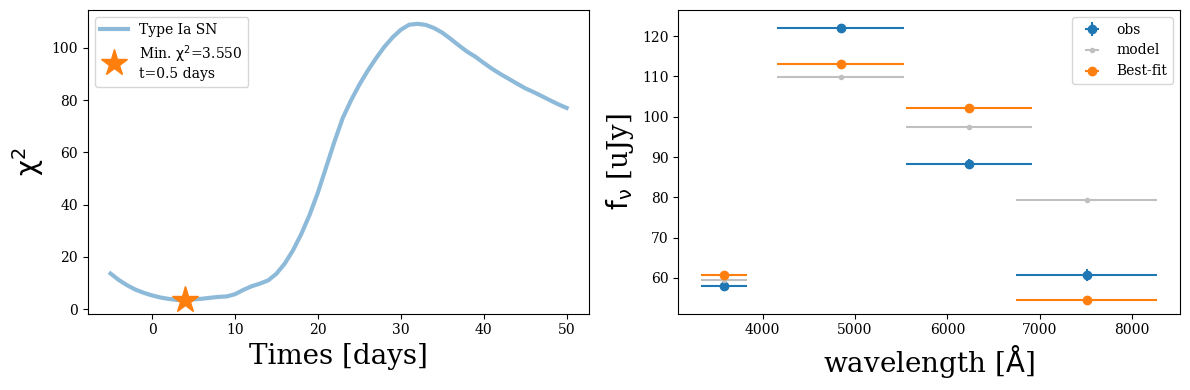

In [11]:

fig = plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(times_cmp, chisqlist, lw=3, alpha=0.5, label='Type Ia SN')

# plt.axvline(x=chisqmin, ls='--', lw=3, c='tomato', alpha=0.75)
plt.plot(times_cmp[indx_min], chisqlist[indx_min],ls='none', marker='*', ms=20, label=r'Min. $\rm \chi^2$='+f"{chisqmin:1.3f}\nt={t:1.1f} days")

plt.xlabel('Times [days]')
plt.ylabel(r'$\rm \chi^{2}$')
plt.legend()

plt.subplot(1, 2, 2)
plt.errorbar(slam, fnuobs, xerr=sbdw/2, yerr=fnuobserr, marker='o', ls='none', label='obs')
plt.errorbar(slam, fnuabs_anwr*popt_anwr, xerr=sbdw/2, c='silver', marker='.', ls='none', label='model')
plt.errorbar(slam, fnuabs*popt, xerr=sbdw/2, marker='o', ls='none', label='Best-fit')

plt.legend()
plt.xlabel(r'wavelength [$\rm \AA$]')
plt.ylabel(r'$\rm f_{\nu}$ [uJy]')
plt.tight_layout()

# Med-band

In [12]:
bandgroup = 'med'
cmpmodellist = sorted(glob.glob(f'../3.table/kn_sim_cube_synphot/*{bandgroup}.ecsv'))+\
	sorted(glob.glob(f'../3.table/sn_sim_sncosmo_synphot/*{bandgroup}.ecsv'))+\
	sorted(glob.glob(f'../3.table/asteroid_sim_smass_synphot/*{bandgroup}.ecsv'))

cmpmodellist[-3:]

# snsimphtmed = '../3.table/sn_sim_sncosmo_synphot/hsaio_v3_type_1a_sn_synphot_med.ecsv'
# simtbl = ascii.read(snsimphtmed)
# simtbl[:10]

['../3.table/sn_sim_sncosmo_synphot/hsaio_v3_type_1a_sn_synphot_med.ecsv',
 '../3.table/asteroid_sim_smass_synphot/smass_10hygiea_c-type_asteroid_synphot_med.ecsv',
 '../3.table/asteroid_sim_smass_synphot/smass_433eros_s-type_asteroid_synphot_med.ecsv']

In [13]:
knobsphtmedlist = sorted(glob.glob(f"../5.result/kn_sim_cube_obs/{bandgroup}_40Mpc/Run*{bandgroup}.ecsv"))
knobsphtmedlist
knobsphtmed = knobsphtmedlist[0]
obstbl = ascii.read(knobsphtmed)
print(knobsphtmed)
obstbl[20:30]

../5.result/kn_sim_cube_obs/med_40Mpc/Run_TP_dyn_all_lanth_wind1_all_md0.001_vd0.05_mw0.003_vw0.15_angle150_synphot_med_obs_d40_iter100.med.ecsv


seed,t,magabs_m400,magapp_m400,snr_m400,magerr_m400,magobs_m400,fnu_m400,fnuobs_m400,fnuerr_m400,detection_m400,magabs_m425,magapp_m425,snr_m425,magerr_m425,magobs_m425,fnu_m425,fnuobs_m425,fnuerr_m425,detection_m425,magabs_m450,magapp_m450,snr_m450,magerr_m450,magobs_m450,fnu_m450,fnuobs_m450,fnuerr_m450,detection_m450,magabs_m475,magapp_m475,snr_m475,magerr_m475,magobs_m475,fnu_m475,fnuobs_m475,fnuerr_m475,detection_m475,magabs_m500,magapp_m500,snr_m500,magerr_m500,magobs_m500,fnu_m500,fnuobs_m500,fnuerr_m500,detection_m500,magabs_m525,magapp_m525,snr_m525,magerr_m525,magobs_m525,fnu_m525,fnuobs_m525,fnuerr_m525,detection_m525,magabs_m550,magapp_m550,snr_m550,magerr_m550,magobs_m550,fnu_m550,fnuobs_m550,fnuerr_m550,detection_m550,magabs_m575,magapp_m575,snr_m575,magerr_m575,magobs_m575,fnu_m575,fnuobs_m575,fnuerr_m575,detection_m575,magabs_m600,magapp_m600,snr_m600,magerr_m600,magobs_m600,fnu_m600,fnuobs_m600,fnuerr_m600,detection_m600,magabs_m625,magapp_m625,snr_m625,magerr_m625,magobs_m625,fnu_m625,fnuobs_m625,fnuerr_m625,detection_m625,magabs_m650,magapp_m650,snr_m650,magerr_m650,magobs_m650,fnu_m650,fnuobs_m650,fnuerr_m650,detection_m650,magabs_m675,magapp_m675,snr_m675,magerr_m675,magobs_m675,fnu_m675,fnuobs_m675,fnuerr_m675,detection_m675,magabs_m700,magapp_m700,snr_m700,magerr_m700,magobs_m700,fnu_m700,fnuobs_m700,fnuerr_m700,detection_m700,magabs_m725,magapp_m725,snr_m725,magerr_m725,magobs_m725,fnu_m725,fnuobs_m725,fnuerr_m725,detection_m725,magabs_m750,magapp_m750,snr_m750,magerr_m750,magobs_m750,fnu_m750,fnuobs_m750,fnuerr_m750,detection_m750,magabs_m775,magapp_m775,snr_m775,magerr_m775,magobs_m775,fnu_m775,fnuobs_m775,fnuerr_m775,detection_m775,magabs_m800,magapp_m800,snr_m800,magerr_m800,magobs_m800,fnu_m800,fnuobs_m800,fnuerr_m800,detection_m800,magabs_m825,magapp_m825,snr_m825,magerr_m825,magobs_m825,fnu_m825,fnuobs_m825,fnuerr_m825,detection_m825,magabs_m850,magapp_m850,snr_m850,magerr_m850,magobs_m850,fnu_m850,fnuobs_m850,fnuerr_m850,detection_m850,magabs_m875,magapp_m875,snr_m875,magerr_m875,magobs_m875,fnu_m875,fnuobs_m875,fnuerr_m875,detection_m875
,d,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),uJy,uJy,uJy,,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),uJy,uJy,uJy,,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),uJy,uJy,uJy,,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),uJy,uJy,uJy,,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),uJy,uJy,uJy,,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),uJy,uJy,uJy,,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),uJy,uJy,uJy,,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),uJy,uJy,uJy,,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),uJy,uJy,uJy,,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),uJy,uJy,uJy,,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),uJy,uJy,uJy,,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),uJy,uJy,uJy,,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),uJy,uJy,uJy,,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),uJy,uJy,uJy,,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),uJy,uJy,uJy,,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),uJy,uJy,uJy,,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),uJy,uJy,uJy,,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),uJy,uJy,uJy,,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),uJy,uJy,uJy,,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),uJy,uJy,uJy,
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,f

In [14]:
t = 0.5
seed = 0
#	Part obs. Table
pobstbl = obstbl[
	(obstbl['t']==t) &
	(obstbl['seed']==seed)
]
pobstbl

seed,t,magabs_m400,magapp_m400,snr_m400,magerr_m400,magobs_m400,fnu_m400,fnuobs_m400,fnuerr_m400,detection_m400,magabs_m425,magapp_m425,snr_m425,magerr_m425,magobs_m425,fnu_m425,fnuobs_m425,fnuerr_m425,detection_m425,magabs_m450,magapp_m450,snr_m450,magerr_m450,magobs_m450,fnu_m450,fnuobs_m450,fnuerr_m450,detection_m450,magabs_m475,magapp_m475,snr_m475,magerr_m475,magobs_m475,fnu_m475,fnuobs_m475,fnuerr_m475,detection_m475,magabs_m500,magapp_m500,snr_m500,magerr_m500,magobs_m500,fnu_m500,fnuobs_m500,fnuerr_m500,detection_m500,magabs_m525,magapp_m525,snr_m525,magerr_m525,magobs_m525,fnu_m525,fnuobs_m525,fnuerr_m525,detection_m525,magabs_m550,magapp_m550,snr_m550,magerr_m550,magobs_m550,fnu_m550,fnuobs_m550,fnuerr_m550,detection_m550,magabs_m575,magapp_m575,snr_m575,magerr_m575,magobs_m575,fnu_m575,fnuobs_m575,fnuerr_m575,detection_m575,magabs_m600,magapp_m600,snr_m600,magerr_m600,magobs_m600,fnu_m600,fnuobs_m600,fnuerr_m600,detection_m600,magabs_m625,magapp_m625,snr_m625,magerr_m625,magobs_m625,fnu_m625,fnuobs_m625,fnuerr_m625,detection_m625,magabs_m650,magapp_m650,snr_m650,magerr_m650,magobs_m650,fnu_m650,fnuobs_m650,fnuerr_m650,detection_m650,magabs_m675,magapp_m675,snr_m675,magerr_m675,magobs_m675,fnu_m675,fnuobs_m675,fnuerr_m675,detection_m675,magabs_m700,magapp_m700,snr_m700,magerr_m700,magobs_m700,fnu_m700,fnuobs_m700,fnuerr_m700,detection_m700,magabs_m725,magapp_m725,snr_m725,magerr_m725,magobs_m725,fnu_m725,fnuobs_m725,fnuerr_m725,detection_m725,magabs_m750,magapp_m750,snr_m750,magerr_m750,magobs_m750,fnu_m750,fnuobs_m750,fnuerr_m750,detection_m750,magabs_m775,magapp_m775,snr_m775,magerr_m775,magobs_m775,fnu_m775,fnuobs_m775,fnuerr_m775,detection_m775,magabs_m800,magapp_m800,snr_m800,magerr_m800,magobs_m800,fnu_m800,fnuobs_m800,fnuerr_m800,detection_m800,magabs_m825,magapp_m825,snr_m825,magerr_m825,magobs_m825,fnu_m825,fnuobs_m825,fnuerr_m825,detection_m825,magabs_m850,magapp_m850,snr_m850,magerr_m850,magobs_m850,fnu_m850,fnuobs_m850,fnuerr_m850,detection_m850,magabs_m875,magapp_m875,snr_m875,magerr_m875,magobs_m875,fnu_m875,fnuobs_m875,fnuerr_m875,detection_m875
,d,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),uJy,uJy,uJy,,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),uJy,uJy,uJy,,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),uJy,uJy,uJy,,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),uJy,uJy,uJy,,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),uJy,uJy,uJy,,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),uJy,uJy,uJy,,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),uJy,uJy,uJy,,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),uJy,uJy,uJy,,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),uJy,uJy,uJy,,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),uJy,uJy,uJy,,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),uJy,uJy,uJy,,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),uJy,uJy,uJy,,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),uJy,uJy,uJy,,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),uJy,uJy,uJy,,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),uJy,uJy,uJy,,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),uJy,uJy,uJy,,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),uJy,uJy,uJy,,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),uJy,uJy,uJy,,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),uJy,uJy,uJy,,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),uJy,uJy,uJy,
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,f

In [15]:
fnuobs = [pobstbl[f"{filte}"].item() for filte in pobstbl.keys() if 'fnuobs_' in filte]
fnuobserr = [pobstbl[f"{filte}"].item() for filte in pobstbl.keys() if 'fnuerr_' in filte]
#	Answer
fnuabs_anwr = [(pobstbl[f"{filte}"].item()*u.ABmag).to(u.uJy).value for filte in pobstbl.keys() if 'magabs' in filte]
popt_anwr, pcov_anwr = curve_fit(func, fnuabs_anwr, fnuobs, sigma=fnuobserr, absolute_sigma=True,)


In [24]:
simtbl = ascii.read(cmpmodellist[-3])
#	S-type
ssimtbl = ascii.read(cmpmodellist[-1])
#	C-type
csimtbl = ascii.read(cmpmodellist[-2])

chisqlist = []

times_cmp = np.unique(simtbl['t'])
for t_cmp in times_cmp:
	psimtbl = simtbl[
		#	Kilonova
		# (simtbl['t']==1.0)
		#	Supernova Type Ia
		(simtbl['t']==t_cmp)
	]
	fnuabs = [(psimtbl[f"{filte}"].item()*u.ABmag).to(u.uJy).value for filte in psimtbl.keys() if filte != 't']
	#	Chi sqaure
	popt, pcov = curve_fit(func, fnuabs, fnuobs, sigma=fnuobserr, absolute_sigma=True,)
	chisq = calc_chisquare(
		obs=fnuabs*popt,
		exp=fnuobs,
		)
	chisqlist.append(chisq)

chisqlist = np.array(chisqlist)
# chisqlist

#	Asteroids
##	S-type
sfnuabs = [(ssimtbl[f"{filte}"].item()*u.ABmag).to(u.uJy).value for filte in ssimtbl.keys() if filte != 't']
spopt, _ = curve_fit(func, sfnuabs, fnuobs, sigma=fnuobserr, absolute_sigma=True,)
schisq = calc_chisquare(
	obs=sfnuabs*spopt,
	exp=fnuobs,
	)
##	C-type
cfnuabs = [(csimtbl[f"{filte}"].item()*u.ABmag).to(u.uJy).value for filte in csimtbl.keys() if filte != 't']
cpopt, _ = curve_fit(func, cfnuabs, fnuobs, sigma=fnuobserr, absolute_sigma=True,)
cchisq = calc_chisquare(
	obs=cfnuabs*cpopt,
	exp=fnuobs,
	)

In [25]:
schisq, cchisq

(548.6338643028937, 459.21822796384663)

In [26]:
indx_min = np.where(chisqlist == chisqlist.min())
chisqmin = chisqlist[indx_min].item()
tmin = times_cmp[indx_min]
psimtbl = simtbl[
	#	Kilonova
	# (simtbl['t']==1.0)
	#	Supernova Type Ia
	(simtbl['t']==tmin)
]
fnuabs = [(psimtbl[f"{filte}"].item()*u.ABmag).to(u.uJy).value for filte in psimtbl.keys() if filte != 't']
popt, pcov = curve_fit(func, fnuabs, fnuobs, sigma=fnuobserr, absolute_sigma=True,)

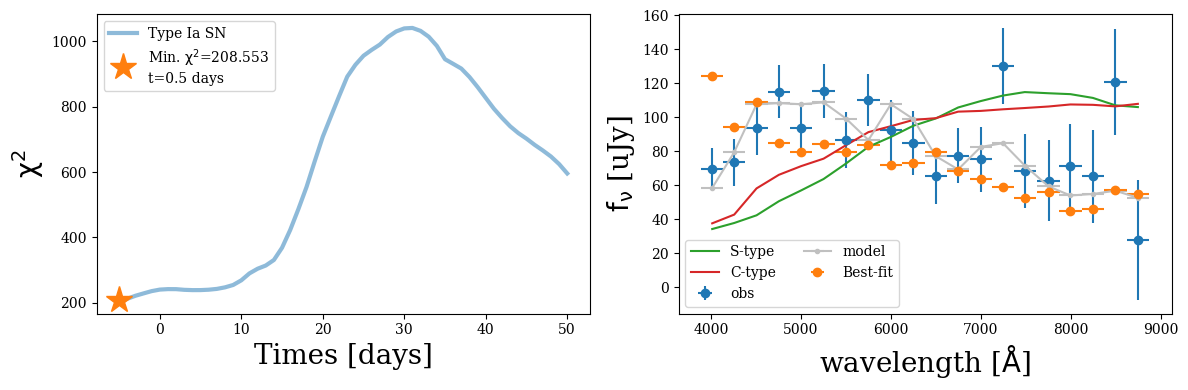

In [30]:

fig = plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(times_cmp, chisqlist, lw=3, alpha=0.5, label='Type Ia SN')

# plt.axvline(x=chisqmin, ls='--', lw=3, c='tomato', alpha=0.75)
plt.plot(times_cmp[indx_min], chisqlist[indx_min],ls='none', marker='*', ms=20, label=r'Min. $\rm \chi^2$='+f"{chisqmin:1.3f}\nt={t:1.1f} days")

plt.xlabel('Times [days]')
plt.ylabel(r'$\rm \chi^{2}$')
plt.legend()

plt.subplot(1, 2, 2)
plt.errorbar(mlam, fnuobs, xerr=mbdw/2, yerr=fnuobserr, marker='o', ls='none', label='obs')
plt.errorbar(mlam, fnuabs_anwr*popt_anwr, xerr=mbdw/2, c='silver', marker='.', ls='-', label='model')
plt.errorbar(mlam, fnuabs*popt, xerr=mbdw/2, marker='o', ls='none', label='Best-fit')
#	Asteroids
plt.plot(mlam, sfnuabs*spopt, label='S-type')
plt.plot(mlam, cfnuabs*cpopt, label='C-type')

plt.legend(ncol=2)
plt.xlabel(r'wavelength [$\rm \AA$]')
plt.ylabel(r'$\rm f_{\nu}$ [uJy]')
plt.tight_layout()

# KN vs KN

In [32]:
len(cmpmodellist)

6303

In [36]:
mdltbl = Table()
mdltbl['model'] = [os.path.basename(cmpmodel) for cmpmodel in cmpmodellist]
mdltbl['t'] = 0.0
mdltbl['popt'] = 0.0
mdltbl['chisq'] = 0.0
mdltbl

model,t,popt,chisq
str86,float64,float64,float64
Run_TP_dyn_all_lanth_wind1_all_md0.001_vd0.05_mw0.001_vw0.05_angle0_synphot_med.ecsv,0.0,0.0,0.0
Run_TP_dyn_all_lanth_wind1_all_md0.001_vd0.05_mw0.001_vw0.05_angle120_synphot_med.ecsv,0.0,0.0,0.0
Run_TP_dyn_all_lanth_wind1_all_md0.001_vd0.05_mw0.001_vw0.05_angle150_synphot_med.ecsv,0.0,0.0,0.0
Run_TP_dyn_all_lanth_wind1_all_md0.001_vd0.05_mw0.001_vw0.05_angle180_synphot_med.ecsv,0.0,0.0,0.0
Run_TP_dyn_all_lanth_wind1_all_md0.001_vd0.05_mw0.001_vw0.05_angle30_synphot_med.ecsv,0.0,0.0,0.0
Run_TP_dyn_all_lanth_wind1_all_md0.001_vd0.05_mw0.001_vw0.05_angle60_synphot_med.ecsv,0.0,0.0,0.0
Run_TP_dyn_all_lanth_wind1_all_md0.001_vd0.05_mw0.001_vw0.05_angle90_synphot_med.ecsv,0.0,0.0,0.0
Run_TP_dyn_all_lanth_wind1_all_md0.001_vd0.05_mw0.001_vw0.15_angle0_synphot_med.ecsv,0.0,0.0,0.0
Run_TP_dyn_all_lanth_wind1_all_md0.001_vd0.05_mw0.001_vw0.15_angle120_synphot_med.ecsv,0.0,0.0,0.0


In [41]:
chisqlist

array([ 183.20074096,  182.52719059,  177.72874047,  169.6008449 ,
        176.4718143 ,  185.34179378,  186.47320117,  184.38099145,
        184.59905761,  183.63896832,  178.02022955,  169.05000326,
        160.29600311,  144.48711547,  122.78450661,  102.96076784,
         95.99721117,  109.97809687,  152.75197534,  231.78489882,
        348.7610676 ,  507.26939168,  684.64680216,  859.1980701 ,
       1018.71245673, 1133.53453181, 1198.2268966 , 1230.3881493 ,
       1246.2501309 , 1265.63801278, 1296.0323683 , 1324.4175684 ,
       1371.28281034, 1463.89230491, 1579.47664332, 1668.5098939 ,
       1723.0595338 , 1752.2590958 , 1792.05228339])

In [50]:
for cc, cmpmodel in enumerate(cmpmodellist):
	print(f"[{cc+1}/{len(cmpmodellist)}] {os.path.basename(cmpmodel)}", end='\r')
	chisqlist = []
	simtbl = ascii.read(cmpmodel)
	times_cmp = np.unique(simtbl['t'])
	for t_cmp in times_cmp:
		psimtbl = simtbl[
			(simtbl['t']==t_cmp)
		]
		fnuabs = [(psimtbl[f"{filte}"].item()*u.ABmag).to(u.uJy).value for filte in psimtbl.keys() if filte != 't']
		#	Chi sqaure
		popt, pcov = curve_fit(func, fnuabs, fnuobs, sigma=fnuobserr, absolute_sigma=True,)
		chisq = calc_chisquare(
			obs=fnuabs*popt,
			exp=fnuobs,
			)
		chisqlist.append(chisq)

	chisqlist = np.array(chisqlist)
	# print(chisqlist)
	#	Pick model
	indx_min = np.where(chisqlist == chisqlist.min())
	chisqmin = chisqlist[indx_min].item()
	tmin = times_cmp[indx_min]
	# psimtbl = simtbl[
	# 	(simtbl['t']==tmin)
	# ]
	# fnuabs = [(psimtbl[f"{filte}"].item()*u.ABmag).to(u.uJy).value for filte in psimtbl.keys() if filte != 't']
	popt, pcov = curve_fit(func, fnuabs, fnuobs, sigma=fnuobserr, absolute_sigma=True,)
	#	Model
	mdltbl['t'][cc] = tmin
	mdltbl['popt'][cc] = popt[0]
	mdltbl['chisq'][cc] = chisqmin


model,t,popt,chisq
,,1.3f,1.3f
str86,float64,float64,float64
Run_TP_dyn_all_lanth_wind1_all_md0.001_vd0.05_mw0.001_vw0.05_angle0_synphot_med.ecsv,0.5,2.834587490682418e-10,162.232
Run_TP_dyn_all_lanth_wind1_all_md0.001_vd0.05_mw0.001_vw0.05_angle120_synphot_med.ecsv,0.648,4.696639734348529e-10,118.620
Run_TP_dyn_all_lanth_wind1_all_md0.001_vd0.05_mw0.001_vw0.05_angle150_synphot_med.ecsv,0.648,3.9462000488462976e-10,127.383
Run_TP_dyn_all_lanth_wind1_all_md0.001_vd0.05_mw0.001_vw0.05_angle180_synphot_med.ecsv,0.5,2.8577036377222637e-10,162.482
Run_TP_dyn_all_lanth_wind1_all_md0.001_vd0.05_mw0.001_vw0.05_angle30_synphot_med.ecsv,0.595,3.858408451759759e-10,129.595
Run_TP_dyn_all_lanth_wind1_all_md0.001_vd0.05_mw0.001_vw0.05_angle60_synphot_med.ecsv,0.648,4.5926616296705877e-10,117.416
Run_TP_dyn_all_lanth_wind1_all_md0.001_vd0.05_mw0.001_vw0.05_angle90_synphot_med.ecsv,0.595,5.209148127693173e-10,136.187
Run_TP_dyn_all_lanth_wind1_all_md0.001_vd0.05_mw0.001_vw0.15_angle0_synphot_med.ecsv,0.42,1.4331104173936156e-09,146.348


In [113]:
mdltbl['chisq'].format = '1.3f'
mdltbl = mdltbl[np.argsort(mdltbl['chisq'])]
mdltbl[:10]

model,t,popt,chisq
,,1.3f,1.3f
str86,float64,float64,float64
Run_TP_dyn_all_lanth_wind2_all_md0.003_vd0.05_mw0.03_vw0.15_angle0_synphot_med.ecsv,0.193,2.5354754167771322e-12,87.247
Run_TP_dyn_all_lanth_wind2_all_md0.1_vd0.15_mw0.1_vw0.15_angle60_synphot_med.ecsv,1.682,5.05599203463975e-13,93.580
Run_TP_dyn_all_lanth_wind2_all_md0.001_vd0.15_mw0.03_vw0.15_angle0_synphot_med.ecsv,0.229,2.2023325495124395e-12,94.693
Run_TP_dyn_all_lanth_wind2_all_md0.1_vd0.05_mw0.1_vw0.15_angle0_synphot_med.ecsv,0.324,6.250362219115318e-13,94.771
Run_TP_dyn_all_lanth_wind2_all_md0.1_vd0.15_mw0.1_vw0.15_angle120_synphot_med.ecsv,1.682,5.03585841374408e-13,94.789
Run_TP_dyn_all_lanth_wind1_all_md0.003_vd0.15_mw0.1_vw0.3_angle120_synphot_med.ecsv,0.5,4.6254118116265386e-11,94.863
Run_TP_dyn_all_lanth_wind1_all_md0.003_vd0.05_mw0.1_vw0.3_angle120_synphot_med.ecsv,0.5,4.275389482078985e-11,94.994
Run_TP_dyn_all_lanth_wind1_all_md0.001_vd0.15_mw0.1_vw0.3_angle60_synphot_med.ecsv,0.5,4.9073364659512235e-11,95.163


Text(0, 0.5, 'N')

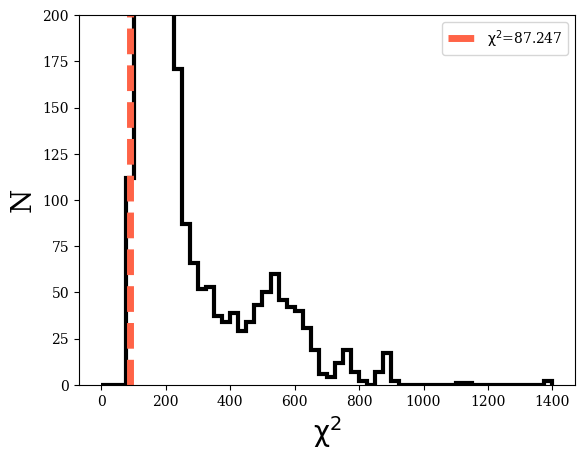

In [81]:
bins = np.arange(0, 1400+25, 25)
# fig = plt.figure(figsize=(18, 6))
# plt.plot(mdltbl['chisq'])
plt.hist(mdltbl['chisq'], bins=bins, histtype='step', color='k', lw=3)
plt.ylim([0, 200])
chisqbest = mdltbl['chisq'].min()
indx_best = np.where(mdltbl['chisq'] == chisqbest)


plt.axvline(x=chisqbest, ls='--', lw=5, c='tomato', label=r'$\rm \chi^2$'+f"={chisqbest:1.3f}")
plt.legend()
plt.xlabel(r'$\rm \chi^2$')
plt.ylabel('N')

In [103]:
mdlbest = mdltbl['model'][indx_best].item()
tbest = mdltbl['t'][indx_best].item()
poptbest = mdltbl['popt'][indx_best].item()

print(f"Best model : {mdlbest}\nBest time  : {tbest:1.3f} days\nBest log10(const) : {np.log10(poptbest):1.3f}")
simtbl = ascii.read(f'../3.table/kn_sim_cube_synphot/{mdlbest}')

psimtbl = simtbl[simtbl['t']==tbest]
fnuabs = np.array([(psimtbl[f"{filte}"].item()*u.ABmag).to(u.uJy).value for filte in psimtbl.keys() if filte != 't'])

psimtbl

Best model : Run_TP_dyn_all_lanth_wind2_all_md0.003_vd0.05_mw0.03_vw0.15_angle0_synphot_med.ecsv
Best time  : 0.193 days
Best log10(const) : -11.596


t,m400,m425,m450,m475,m500,m525,m550,m575,m600,m625,m650,m675,m700,m725,m750,m775,m800,m825,m850,m875
d,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB)
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0.193,-9.615,-9.868,-10.144,-10.162,-10.135,-10.237,-10.195,-10.232,-9.993,-9.812,-9.785,-9.930,-9.973,-9.979,-9.830,-9.863,-9.849,-9.813,-9.782,-9.560


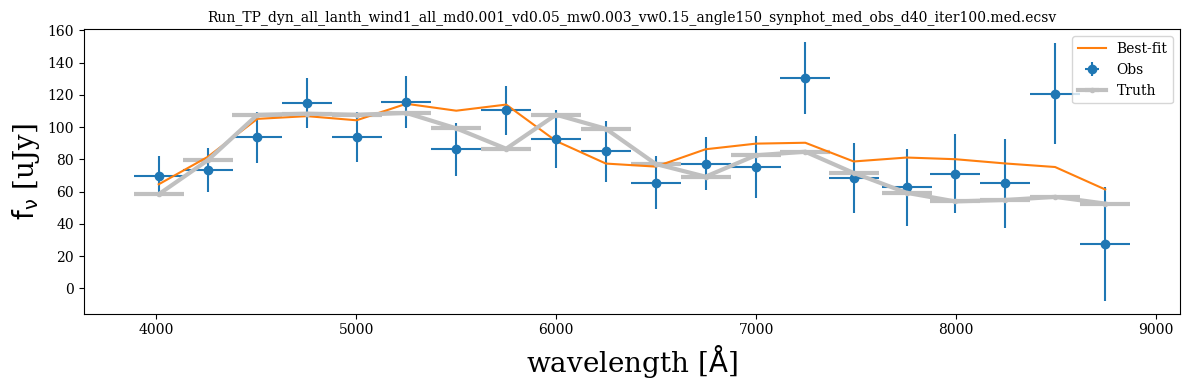

In [116]:
fig = plt.figure(figsize=(12, 4))

# plt.subplot()
plt.errorbar(mlam, fnuobs, xerr=mbdw/2, yerr=fnuobserr, marker='o', ls='none', label='Obs')
plt.errorbar(mlam, fnuabs_anwr*popt_anwr, xerr=mbdw/2, c='silver', marker='.', ls='-', lw=3, label='Truth')
plt.plot(mlam, fnuabs*poptbest, label='Best-fit')

plt.title(os.path.basename(knobsphtmed), fontsize=10)
plt.legend()
plt.xlabel(r'wavelength [$\rm \AA$]')
plt.ylabel(r'$\rm f_{\nu}$ [uJy]')
plt.tight_layout()